# Entrenamiento en intervalos de tiempo de retraso múltiple #

In [1]:
import os
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# Inicializar entorno de rutas en google drive para carga de archivos 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Nombre del directorio de datos para rutas de ejecucion en ENTORNO LOCAL
PATH = "/content/drive/MyDrive/IABD_Proyecto/IABD_PRJ_Dev_PeakyBlinders/datoscsv/"
pathdatos = os.path.join(PATH)

In [4]:
# Convertimos las series temporales para aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# insertamos la secuencia (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Creamos la secuencia de pronostico (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# Juntamos todo
	agg = concat(cols, axis=1)
	agg.columns = names
	# Eliminamos filas con valores NaN
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# cargamos dataset
#dataset = read_csv('../../datos/pollution.csv', header=0, index_col=0)
dataset = read_csv(pathdatos+'pollution.csv', header=0, index_col=0)
values = dataset.values
# Forzamos la codificación como valores enteros
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Aseguramos que todos los datos son float
values = values.astype('float32')
# Normalizamos las caracteristicas
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Vamos a entrenar el modelo en varios ventanas de tiempo anteriores.

No escontramos con varias fases de desarrollo del supuesto :
1. Se enmarcará el problema adecuadamente erspecto a la llamada a la funcion series_to_supervised().

La ventana tendrá 3 horas de datos como entrada.

También tenga en cuenta que ya no se muestran explícitamente las columnas de todos los demás campos en ob(t).

In [5]:
# Especificamos el numero de ventanas de horas
n_hours = 3
n_features = 8
# Enmarcamos como aprendizaje supervisado
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(43797, 32)


A continuación, debemos ser muy cuidadosos al especificar la columna para entrada y salida.

Tenemos 3 * 8 + 8 columnas en nuestro conjunto de datos.
- Tomaremos 3 * 8 o 24 columnas como entrada para las observaciones de todas las funciones durante las 3 horas anteriores.
- Tomaremos solo la variable contaminación como salida a la hora siguiente

In [6]:
# Separamos entre train y tests
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# separamos entre input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


A continuación, remodelamos los datos de entrada correctamente para reflejar los pasos de tiempo y las características.

In [7]:
# remodelamos la entrada para que sea 3D [muestras, intervalos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Ajustamos el modelo.

Evaluamos el modelo a partir de la reconstruccion de las filas con 8 columnas adecuadas. Se invertirá la operación de escalado para que `y` y `yhat` vuelvan a la escala original de manera que podamos calcular el RMSE.

Esencialmente concatenamos la columna `y` o `yhat` con las últimas 7 características del conjunto de datos de prueba para invertir la escala.

Epoch 1/50
122/122 - 4s - loss: 0.0452 - val_loss: 0.0479 - 4s/epoch - 30ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0250 - val_loss: 0.0260 - 1s/epoch - 9ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0207 - val_loss: 0.0203 - 1s/epoch - 9ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0209 - val_loss: 0.0196 - 2s/epoch - 13ms/step
Epoch 5/50
122/122 - 2s - loss: 0.0200 - val_loss: 0.0191 - 2s/epoch - 13ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0193 - val_loss: 0.0190 - 2s/epoch - 13ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0194 - val_loss: 0.0185 - 1s/epoch - 9ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0192 - val_loss: 0.0183 - 1s/epoch - 9ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0184 - val_loss: 0.0180 - 2s/epoch - 13ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0181 - val_loss: 0.0176 - 1s/epoch - 9ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0175 - val_loss: 0.0171 - 2s/epoch - 13ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0171 - 1s/epoch - 9ms/step
Epoch 13/50
122/122 - 2s - loss

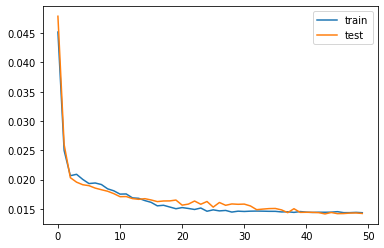

In [8]:
# Diseñamos el modelo
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Mostramos grafico de history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# Hacemos una prediccion
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invertimos la escala para el pronóstico
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invertimos la escala para los datos actuales
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Finalmente calculamos RMSE

In [ ]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.963
